# Análisis del contenido - Plataforma Streaming

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import sys
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) 
sys.path.append(project_root)

In [3]:
from plugins.helpers.my_utilities import get_db_engine

In [4]:
conn = get_db_engine()

In [5]:
# Configuración de estilo
plt.style.use('ggplot')
sns.set_palette("pastel")

#### Distribución de planes de suscripción

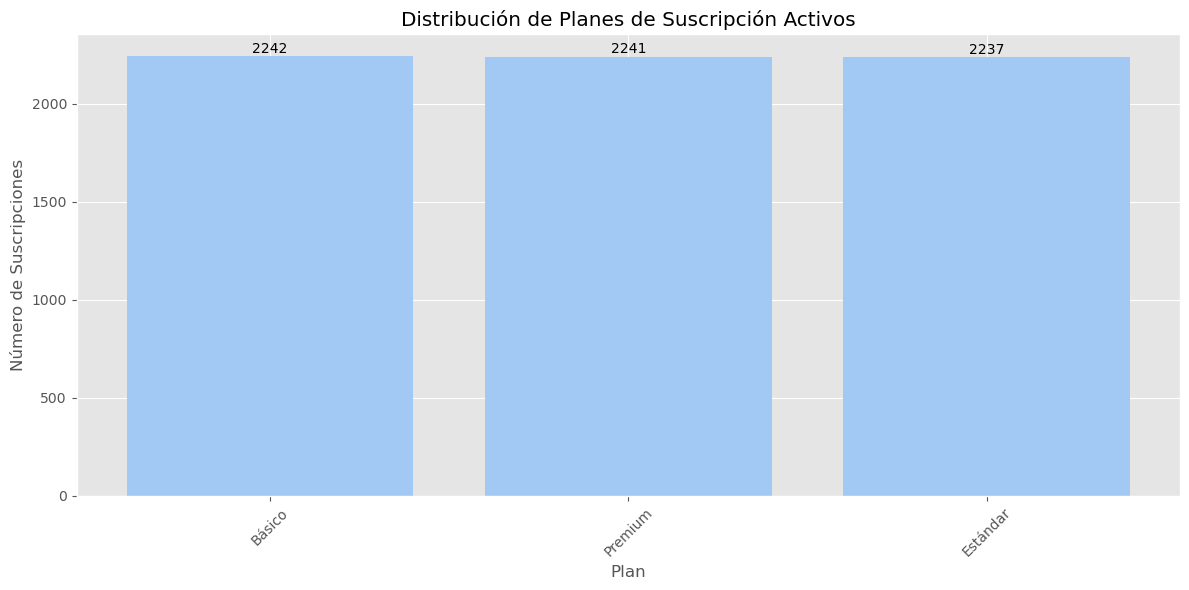

In [6]:
query_1 = """
SELECT 
    sp.name as plan_name,
    COUNT(s.subscription_id) as total_suscripciones,
    sp.price_monthly,
    sp.max_simultaneous_screens,
    sp.video_quality
FROM subscription_plans sp
LEFT JOIN subscriptions s ON sp.plan_id = s.plan_id
WHERE s.status = 'active'
GROUP BY sp.plan_id, sp.name, sp.price_monthly, sp.max_simultaneous_screens, sp.video_quality
ORDER BY total_suscripciones DESC;
"""

df_suscripciones = pd.read_sql(query_1, conn)

# Gráfico de distribución de planes
plt.figure(figsize=(12, 6))
bars = plt.bar(df_suscripciones['plan_name'], df_suscripciones['total_suscripciones'])
plt.title('Distribución de Planes de Suscripción Activos')
plt.xlabel('Plan')
plt.ylabel('Número de Suscripciones')
plt.xticks(rotation=45)

# Agregar valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Dado que no hay un plan claramente preferido, podría haber espacio para que la empresa ajuste características o precios con el fin de destacar un plan específico según su estrategia (por ejemplo, empujar más al Premium si es el de mayor margen).

#### Contenido por género

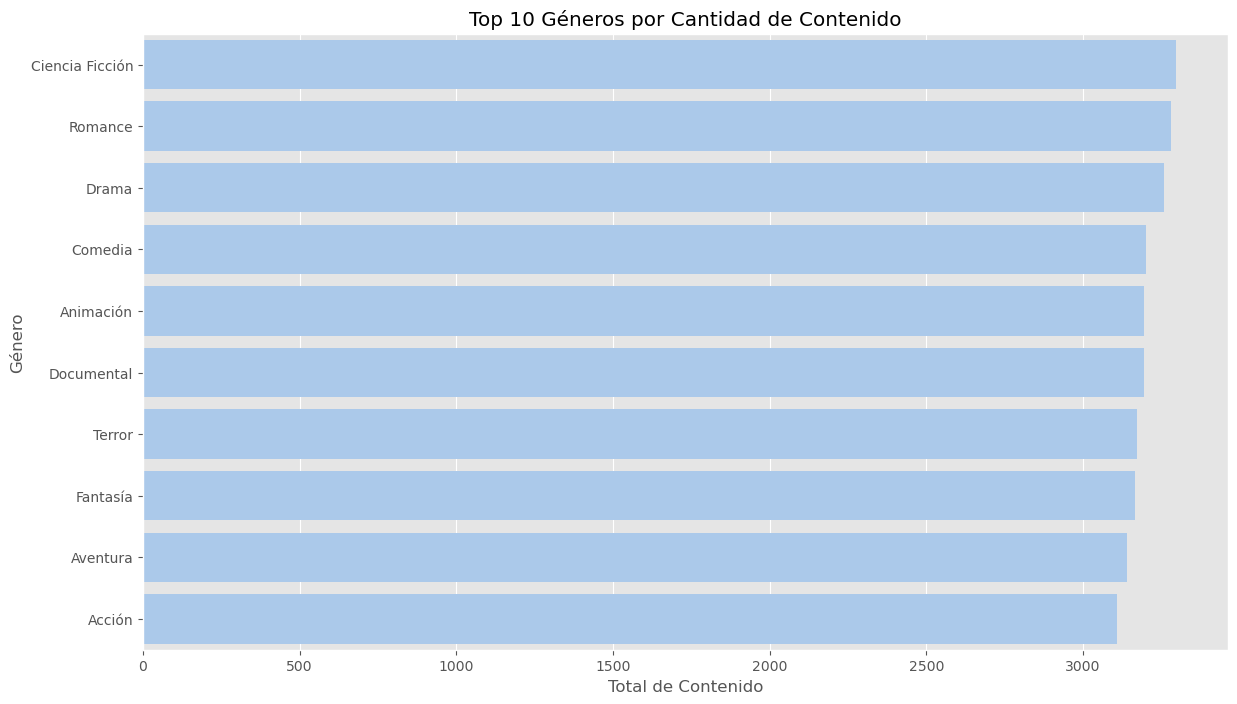

In [8]:
query_2 = """
SELECT 
    g.name as genero,
    COUNT(cg.content_id) as total_contenido,
    AVG(c.duration_minutes) as duracion_promedio,
    COUNT(DISTINCT CASE WHEN c.content_type = 'movie' THEN c.content_id END) as peliculas,
    COUNT(DISTINCT CASE WHEN c.content_type = 'series' THEN c.content_id END) as series
FROM genres g
JOIN content_genres cg ON g.genre_id = cg.genre_id
JOIN content c ON cg.content_id = c.content_id
GROUP BY g.name
ORDER BY total_contenido DESC;
"""

df_generos = pd.read_sql(query_2, conn)

# Gráfico de contenido por género
plt.figure(figsize=(14, 8))
sns.barplot(data=df_generos.head(10), x='total_contenido', y='genero')
plt.title('Top 10 Géneros por Cantidad de Contenido')
plt.xlabel('Total de Contenido')
plt.ylabel('Género')
plt.show()

Los géneros incluidos (Ciencia Ficción, Romance, Drama, Comedia, Animación, Documental, Terror, Fantasía, Aventura y Acción) son justamente los más comunes en catálogos de cine y series, lo cual confirma su relevancia en la industria.
La diferencia entre el primero y el último es mínima. Esto puede deberse a que la clasificación de géneros es amplia y muchos contenidos se catalogan en múltiples géneros, generando conteos muy similares.

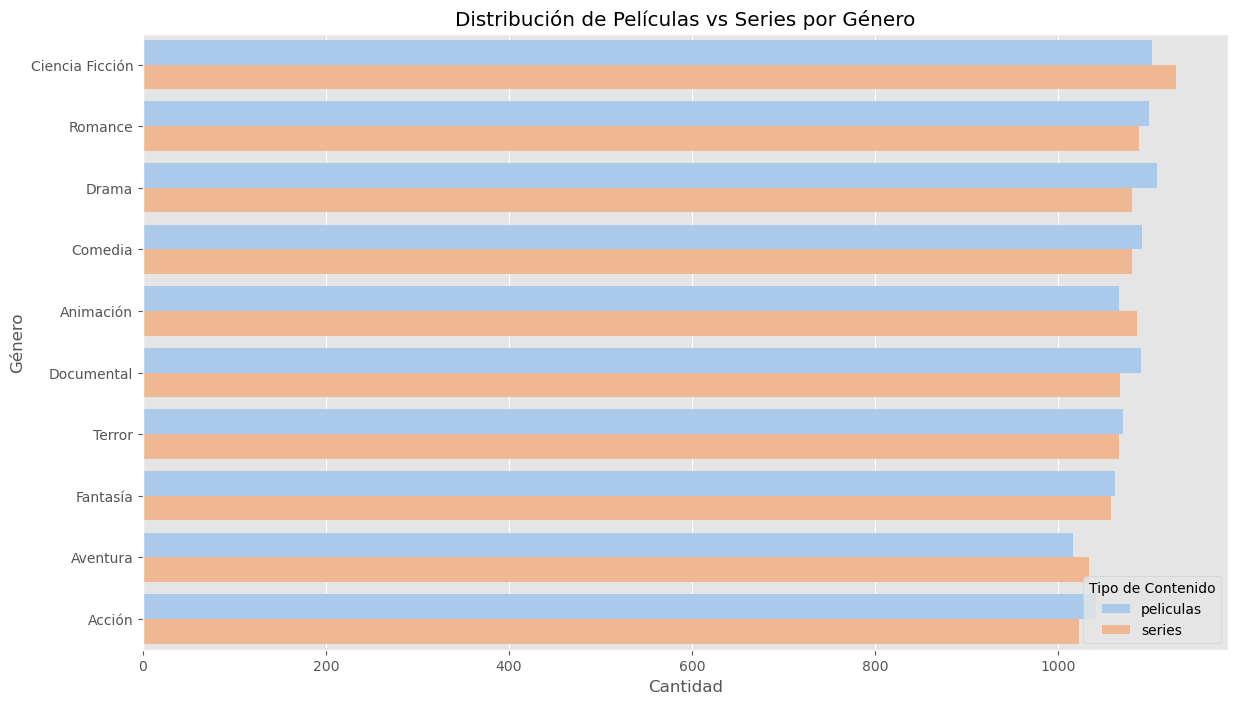

In [9]:
# Gráfico de proporción películas vs series por género
df_melted = df_generos.melt(id_vars=['genero'], value_vars=['peliculas', 'series'], 
                           var_name='tipo', value_name='cantidad')

plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted.head(20), x='cantidad', y='genero', hue='tipo')
plt.title('Distribución de Películas vs Series por Género')
plt.xlabel('Cantidad')
plt.ylabel('Género')
plt.legend(title='Tipo de Contenido')
plt.show()

#### Actividad de usuarios por hora del día

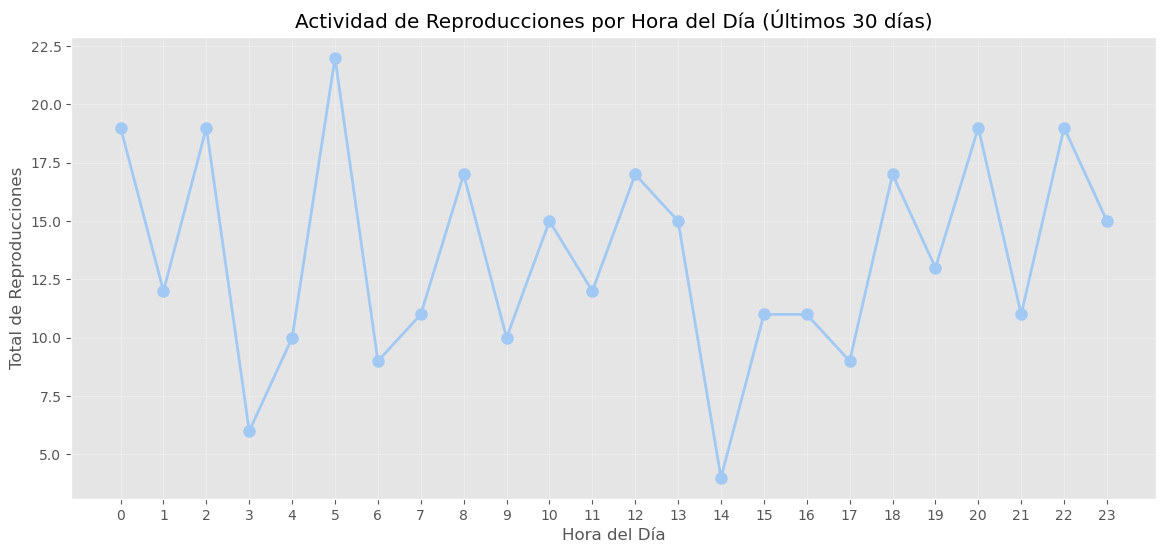

In [22]:
query_3 = """
SELECT 
    EXTRACT(HOUR FROM start_time) as hora,
    COUNT(play_id) as total_reproducciones,
    COUNT(DISTINCT user_id) as usuarios_unicos,
    AVG(EXTRACT(EPOCH FROM (end_time - start_time))/60) as duracion_promedio_min
FROM plays
WHERE start_time >= CURRENT_DATE - INTERVAL '30 days'
GROUP BY EXTRACT(HOUR FROM start_time)
ORDER BY hora;
"""

df_actividad = pd.read_sql(query_3, conn)

# Gráfico de actividad por hora
plt.figure(figsize=(14, 6))
plt.plot(df_actividad['hora'], df_actividad['total_reproducciones'], marker='o', linewidth=2, markersize=8)
plt.title('Actividad de Reproducciones por Hora del Día (Últimos 30 días)')
plt.xlabel('Hora del Día')
plt.ylabel('Total de Reproducciones')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

El horario con menor cantidad de reproducciones es las 14 h, con menos de 5 reproducciones.
También se observa baja actividad alrededor de las 3 h, 6 h, 9 h y 17 h.
No parece haber una tendencia clara de “mañana” vs “tarde”, ya que la actividad es bastante dispersa a lo largo del día.
Sin embargo, se notan más picos de actividad en la madrugada y noche (0–5 h y 20–23 h), lo que podría indicar que los usuarios consumen más contenido fuera de horarios laborales/estudio.

#### Engagement por tipo de contenido

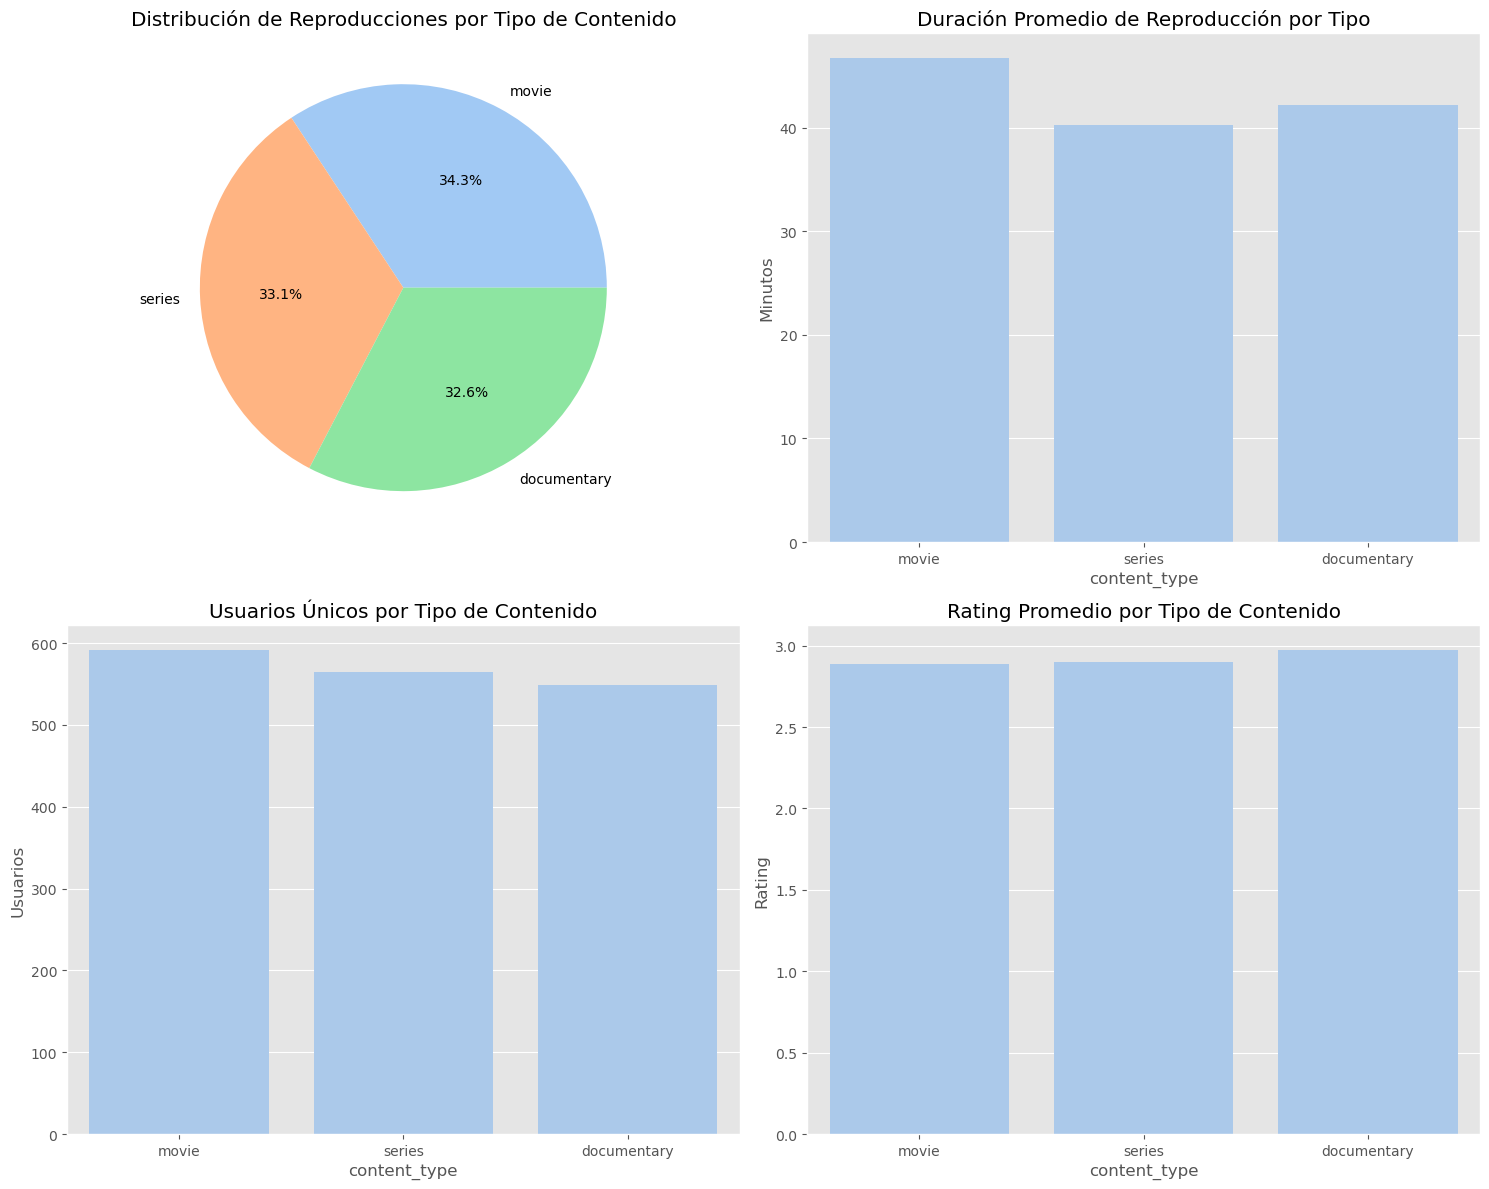

In [8]:
query_4 = """
SELECT 
    c.content_type,
    COUNT(p.play_id) as total_reproducciones,
    COUNT(DISTINCT p.user_id) as usuarios_unicos,
    AVG(EXTRACT(EPOCH FROM (p.end_time - p.start_time))/60) as duracion_promedio_min,
    AVG(r.score) as rating_promedio
FROM content c
LEFT JOIN plays p ON c.content_id = p.content_id
LEFT JOIN ratings r ON c.content_id = r.content_id
WHERE p.start_time >= CURRENT_DATE - INTERVAL '90 days'
GROUP BY c.content_type
ORDER BY total_reproducciones DESC;
"""

df_engagement = pd.read_sql(query_4, conn)

# Gráfico de engagement
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Reproducciones por tipo
axes[0,0].pie(df_engagement['total_reproducciones'], labels=df_engagement['content_type'], autopct='%1.1f%%')
axes[0,0].set_title('Distribución de Reproducciones por Tipo de Contenido')

# Duración promedio
sns.barplot(data=df_engagement, x='content_type', y='duracion_promedio_min', ax=axes[0,1])
axes[0,1].set_title('Duración Promedio de Reproducción por Tipo')
axes[0,1].set_ylabel('Minutos')

# Usuarios únicos
sns.barplot(data=df_engagement, x='content_type', y='usuarios_unicos', ax=axes[1,0])
axes[1,0].set_title('Usuarios Únicos por Tipo de Contenido')
axes[1,0].set_ylabel('Usuarios')

# Rating promedio
sns.barplot(data=df_engagement, x='content_type', y='rating_promedio', ax=axes[1,1])
axes[1,1].set_title('Rating Promedio por Tipo de Contenido')
axes[1,1].set_ylabel('Rating')

plt.tight_layout()
plt.show()

* Ningún tipo de contenido domina significativamente. La plataforma tiene un consumo equilibrado entre los tres.
* Los usuarios tienden a mirar más tiempo las películas que las series, probablemente porque el formato de película se consume de manera más continua, mientras que las series suelen cortarse entre episodios.
* Las películas atraen a la mayor cantidad de usuarios únicos, aunque la diferencia no es grande. Esto refuerza la idea de un consumo balanceado, pero con ligera preferencia por el cine.

#### Crecimiento mensual de usuarios

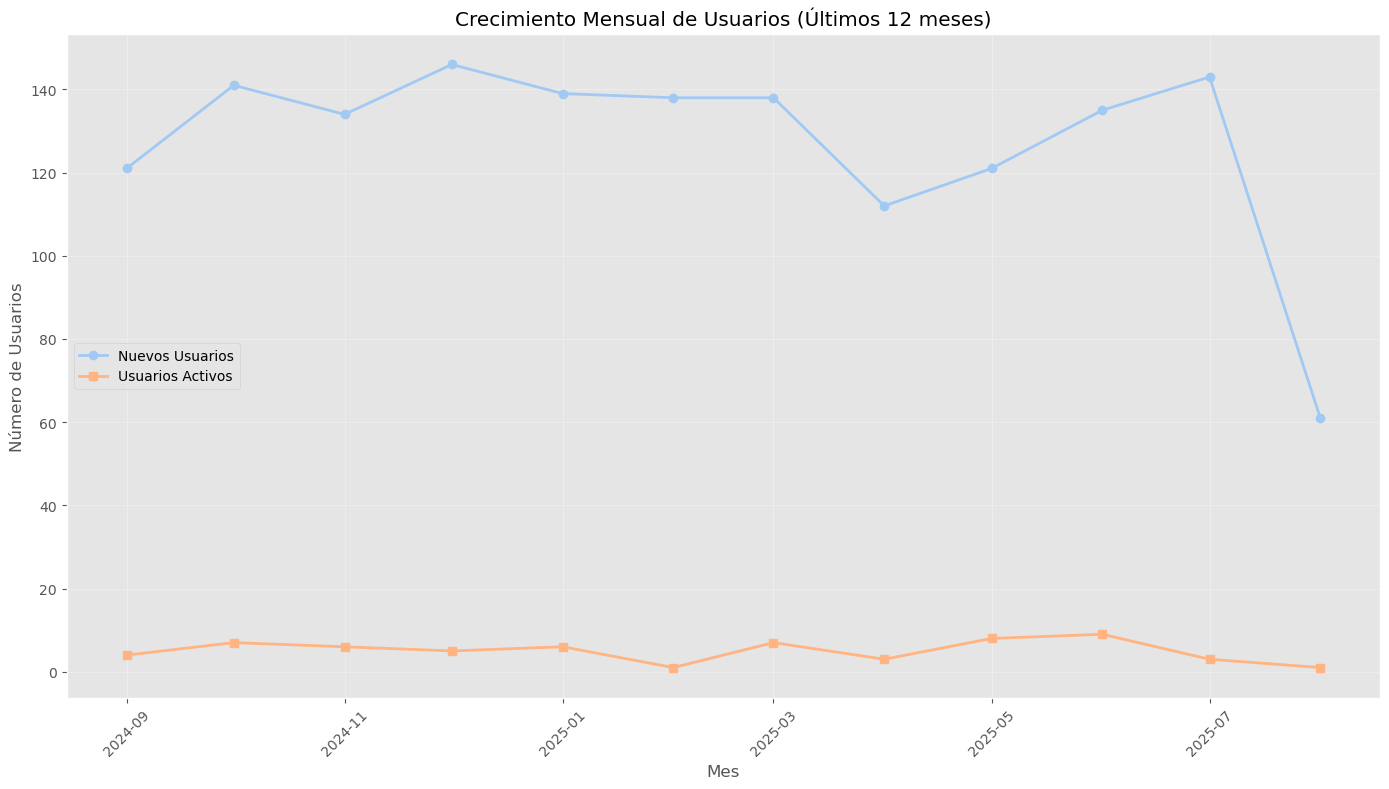

In [24]:
query_5 = """
SELECT 
    DATE_TRUNC('month', registration_date) as mes,
    COUNT(user_id) as nuevos_usuarios,
    COUNT(CASE WHEN last_login >= CURRENT_DATE - INTERVAL '30 days' THEN user_id END) as usuarios_activos
FROM users
WHERE registration_date >= CURRENT_DATE - INTERVAL '12 months'
GROUP BY DATE_TRUNC('month', registration_date)
ORDER BY mes;
"""

df_crecimiento = pd.read_sql(query_5, conn)
df_crecimiento['mes'] = pd.to_datetime(df_crecimiento['mes'])

# Gráfico de crecimiento
plt.figure(figsize=(14, 8))
plt.plot(df_crecimiento['mes'], df_crecimiento['nuevos_usuarios'], marker='o', label='Nuevos Usuarios', linewidth=2)
plt.plot(df_crecimiento['mes'], df_crecimiento['usuarios_activos'], marker='s', label='Usuarios Activos', linewidth=2)
plt.title('Crecimiento Mensual de Usuarios (Últimos 12 meses)')
plt.xlabel('Mes')
plt.ylabel('Número de Usuarios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El número de nuevos usuarios muestra una gran fluctuación a lo largo del año. Hay picos significativos, como el de octubre de 2024 y el de junio de 2025, donde se supera la marca de los 140 usuarios. Estos picos pueden estar relacionados con campañas de marketing, promociones o lanzamientos de nuevos productos. Por otro lado, también hay caídas abruptas, como la del último mes, julio de 2025, donde la cifra cae a poco más de 60 nuevos usuarios.
La empresa es buena atrayendo a gente nueva, pero tiene un grave problema para retenerla. Es fundamental que investiguen por qué los usuarios no se quedan y trabajen en mejorar la experiencia del producto para que se vuelvan usuarios activos a largo plazo.

#### Uso de dispositivos

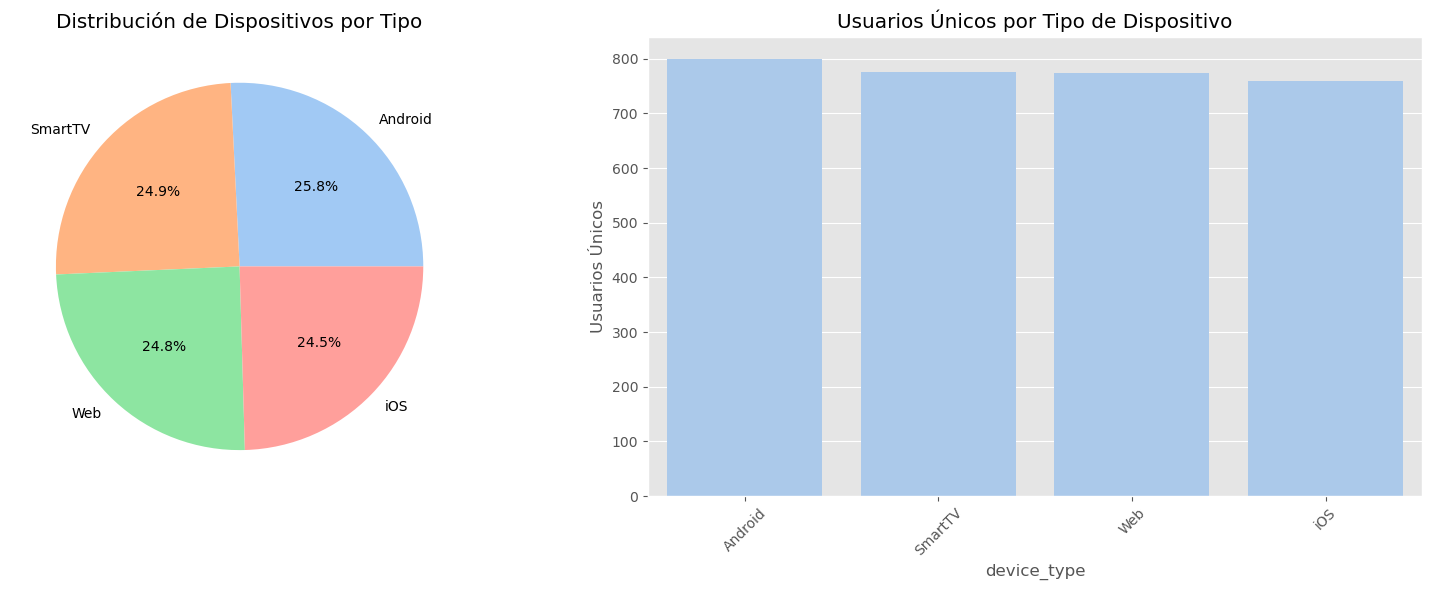

In [25]:
query_7 = """
SELECT 
    device_type,
    COUNT(device_id) as total_dispositivos,
    COUNT(DISTINCT user_id) as usuarios_unicos,
    AVG(EXTRACT(EPOCH FROM (CURRENT_TIMESTAMP - last_connection))/3600) as horas_desde_ultima_conexion
FROM devices
WHERE last_connection >= CURRENT_DATE - INTERVAL '90 days'
GROUP BY device_type
ORDER BY total_dispositivos DESC;
"""

df_dispositivos = pd.read_sql(query_7, conn)

# Gráfico de dispositivos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dispositivos por tipo
axes[0].pie(df_dispositivos['total_dispositivos'], labels=df_dispositivos['device_type'], autopct='%1.1f%%')
axes[0].set_title('Distribución de Dispositivos por Tipo')

# Actividad por dispositivo
sns.barplot(data=df_dispositivos, x='device_type', y='usuarios_unicos', ax=axes[1])
axes[1].set_title('Usuarios Únicos por Tipo de Dispositivo')
axes[1].set_ylabel('Usuarios Únicos')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

* En el gráfico de torta se observa que la participación de cada tipo de dispositivo (Android, iOS, Web y SmartTV) está bastante balanceada.
* Android lidera apenas con un 25,8%, mientras que iOS tiene el menor porcentaje con 24,5%. La diferencia entre el mayor y el menor segmento es mínima (1,3%).
* En el gráfico de barras, Android también aparece como el dispositivo con mayor cantidad de usuarios únicos.
* Es importante dar el mismo nivel de soporte y experiencia de usuario en todas las plataformas porque ninguna puede descuidarse.

#### Ranking de contenido por género

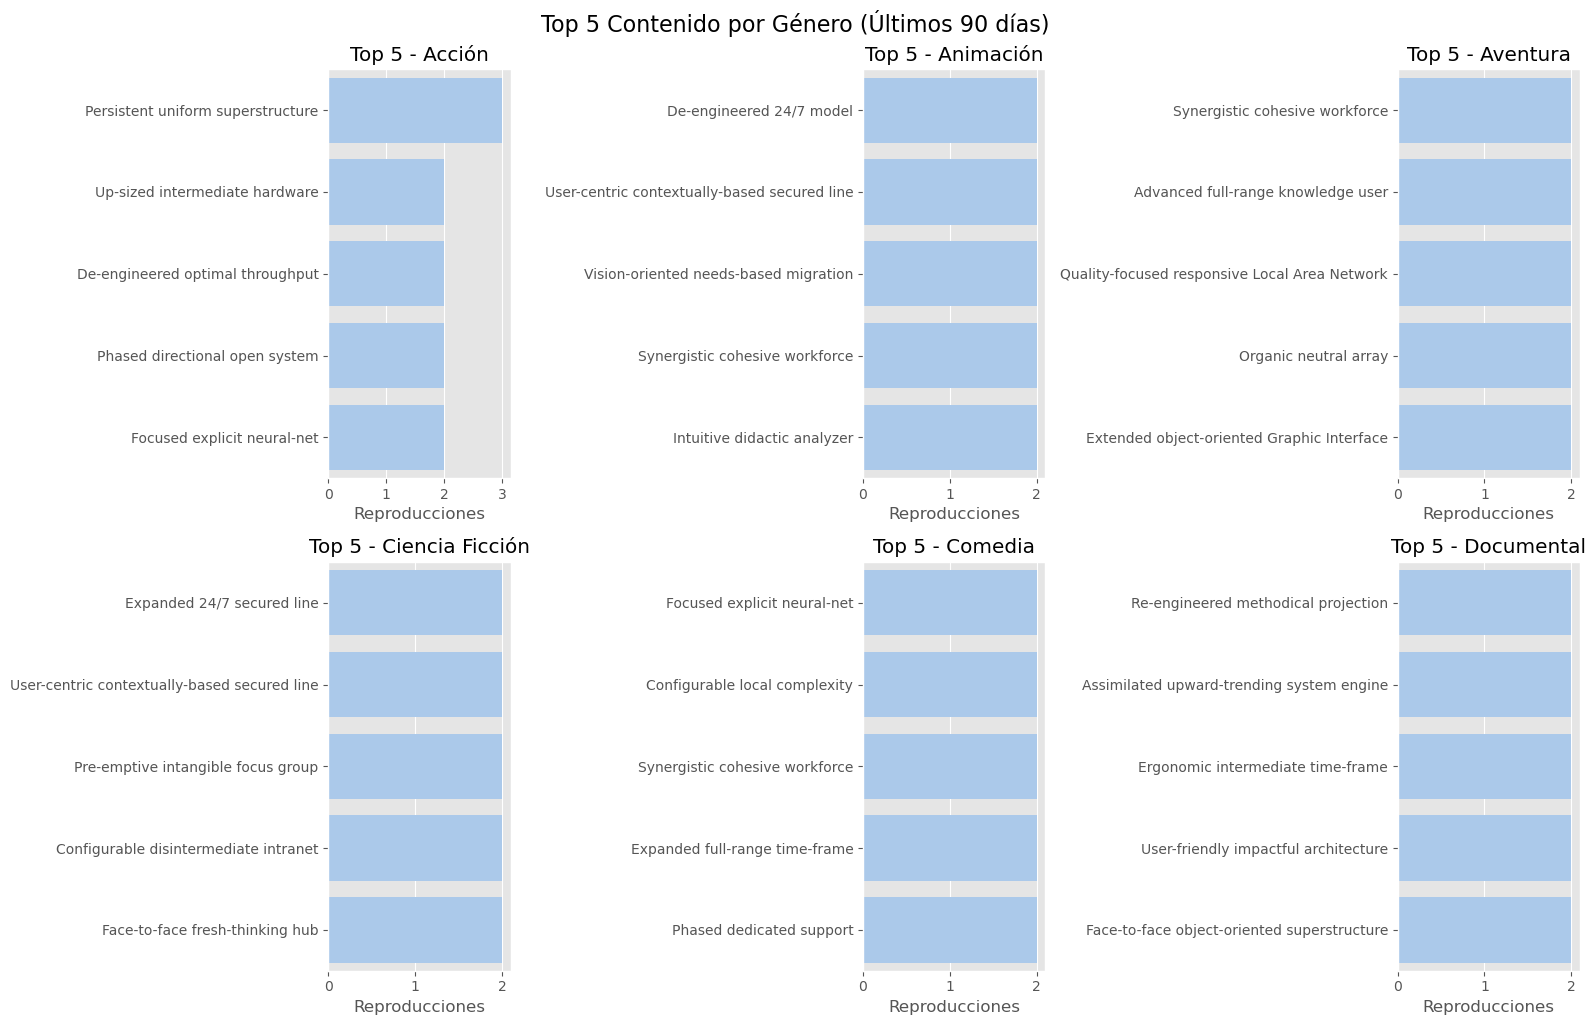

In [10]:
query_1 = """
WITH contenido_rank AS (
    SELECT 
        c.content_id,
        c.title,
        c.content_type,
        g.name as genero,
        COUNT(p.play_id) as total_reproducciones,
        ROW_NUMBER() OVER (PARTITION BY g.name ORDER BY COUNT(p.play_id) DESC) as ranking_genero,
        RANK() OVER (ORDER BY COUNT(p.play_id) DESC) as ranking_global
    FROM content c
    JOIN content_genres cg ON c.content_id = cg.content_id
    JOIN genres g ON cg.genre_id = g.genre_id
    LEFT JOIN plays p ON c.content_id = p.content_id
    WHERE p.start_time >= CURRENT_DATE - INTERVAL '90 days'
    GROUP BY c.content_id, c.title, c.content_type, g.name
)
SELECT *
FROM contenido_rank
WHERE ranking_genero <= 5
ORDER BY genero, ranking_genero;
"""

df_ranking_genero = pd.read_sql(query_1, conn)

# Gráfico de top contenido por género
plt.figure(figsize=(16, 10))
top_generos = df_ranking_genero['genero'].value_counts().index[:6]

for i, genero in enumerate(top_generos, 1):
    plt.subplot(2, 3, i)
    data = df_ranking_genero[df_ranking_genero['genero'] == genero].head(5)
    sns.barplot(data=data, x='total_reproducciones', y='title')
    plt.title(f'Top 5 - {genero}')
    plt.xlabel('Reproducciones')
    plt.ylabel('')
    plt.tight_layout()

plt.suptitle('Top 5 Contenido por Género (Últimos 90 días)', fontsize=16, y=1.02)
plt.show()

En todos los gráficos, el número de reproducciones de los 5 contenidos principales es consistentemente bajo y se agrupa en un rango muy estrecho, generalmente entre 0 y 2 reproducciones. Esto indica que no hay un contenido "hit" o un claro favorito que se destaque del resto. La distribución es muy plana.

#### Tendencia de actividad mensual por usuario

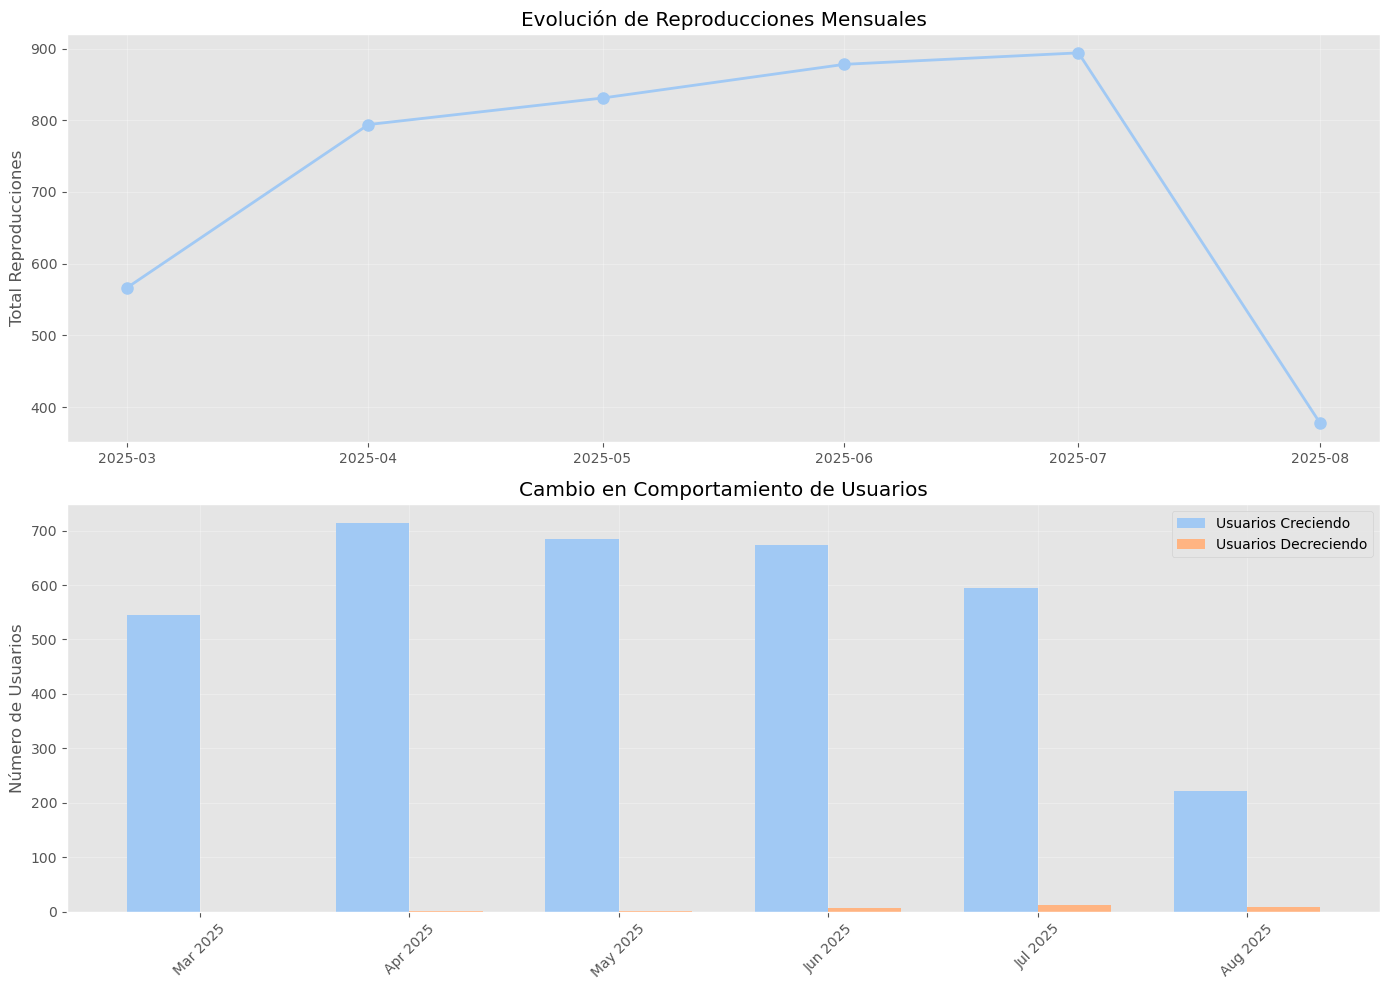

In [12]:
query_2 = """
WITH actividad_mensual AS (
    SELECT 
        u.user_id,
        u.name as usuario,
        DATE_TRUNC('month', p.start_time) as mes,
        COUNT(p.play_id) as reproducciones_mes,
        LAG(COUNT(p.play_id)) OVER (PARTITION BY u.user_id ORDER BY DATE_TRUNC('month', p.start_time)) as reproducciones_mes_anterior,
        LEAD(COUNT(p.play_id)) OVER (PARTITION BY u.user_id ORDER BY DATE_TRUNC('month', p.start_time)) as reproducciones_mes_siguiente
    FROM users u
    JOIN plays p ON u.user_id = p.user_id
    WHERE p.start_time >= CURRENT_DATE - INTERVAL '6 months'
    GROUP BY u.user_id, u.name, DATE_TRUNC('month', p.start_time)
)
SELECT 
    mes,
    SUM(reproducciones_mes) as total_reproducciones,
    SUM(CASE WHEN reproducciones_mes > COALESCE(reproducciones_mes_anterior, 0) THEN 1 ELSE 0 END) as usuarios_creciendo,
    SUM(CASE WHEN reproducciones_mes < COALESCE(reproducciones_mes_anterior, 0) THEN 1 ELSE 0 END) as usuarios_decreciendo,
    AVG(reproducciones_mes) as promedio_reproducciones
FROM actividad_mensual
GROUP BY mes
ORDER BY mes;
"""

df_tendencia_usuarios = pd.read_sql(query_2, conn)
df_tendencia_usuarios['mes'] = pd.to_datetime(df_tendencia_usuarios['mes'])

# Gráfico de tendencia
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Total reproducciones
axes[0].plot(df_tendencia_usuarios['mes'], df_tendencia_usuarios['total_reproducciones'], 
            marker='o', linewidth=2, markersize=8)
axes[0].set_title('Evolución de Reproducciones Mensuales')
axes[0].set_ylabel('Total Reproducciones')
axes[0].grid(True, alpha=0.3)

# Usuarios creciendo/decreciendo
width = 0.35
x = np.arange(len(df_tendencia_usuarios))
axes[1].bar(x - width/2, df_tendencia_usuarios['usuarios_creciendo'], width, label='Usuarios Creciendo')
axes[1].bar(x + width/2, df_tendencia_usuarios['usuarios_decreciendo'], width, label='Usuarios Decreciendo')
axes[1].set_title('Cambio en Comportamiento de Usuarios')
axes[1].set_ylabel('Número de Usuarios')
axes[1].set_xticks(x)
axes[1].set_xticklabels([d.strftime('%b %Y') for d in df_tendencia_usuarios['mes']], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

El gráfico "Evolución de Reproducciones Mensuales," muestra un crecimiento constante en las reproducciones totales desde marzo hasta julio de 2025. Sin embargo, hay un descenso drástico en agosto. Las reproducciones pasaron de casi 900 en julio a menos de 400 en agosto.
El gráfico inferior, "Cambio en Comportamiento de Usuarios," proporciona más contexto. Observa la cantidad de "Usuarios Creciendo" (barras azules) y "Usuarios Decreciendo" (barras anaranjadas). De marzo a mayo, la cantidad de usuarios crecientes se mantiene alta, lo que coincide con el aumento de reproducciones. A partir de junio y julio, la cantidad de usuarios crecientes disminuye, aunque el número de reproducciones se mantiene estable o incluso aumenta ligeramente, lo que podría indicar que los usuarios que quedan son más activos.
La caída repentina en agosto es la clave. El segundo gráfico muestra que, en agosto, el número de usuarios crecientes se reduce significativamente. Este descenso de usuarios en agosto se correlaciona directamente con la caída masiva de reproducciones que se ve en el primer gráfico.



#### Tendencia de crecimiento con funciones

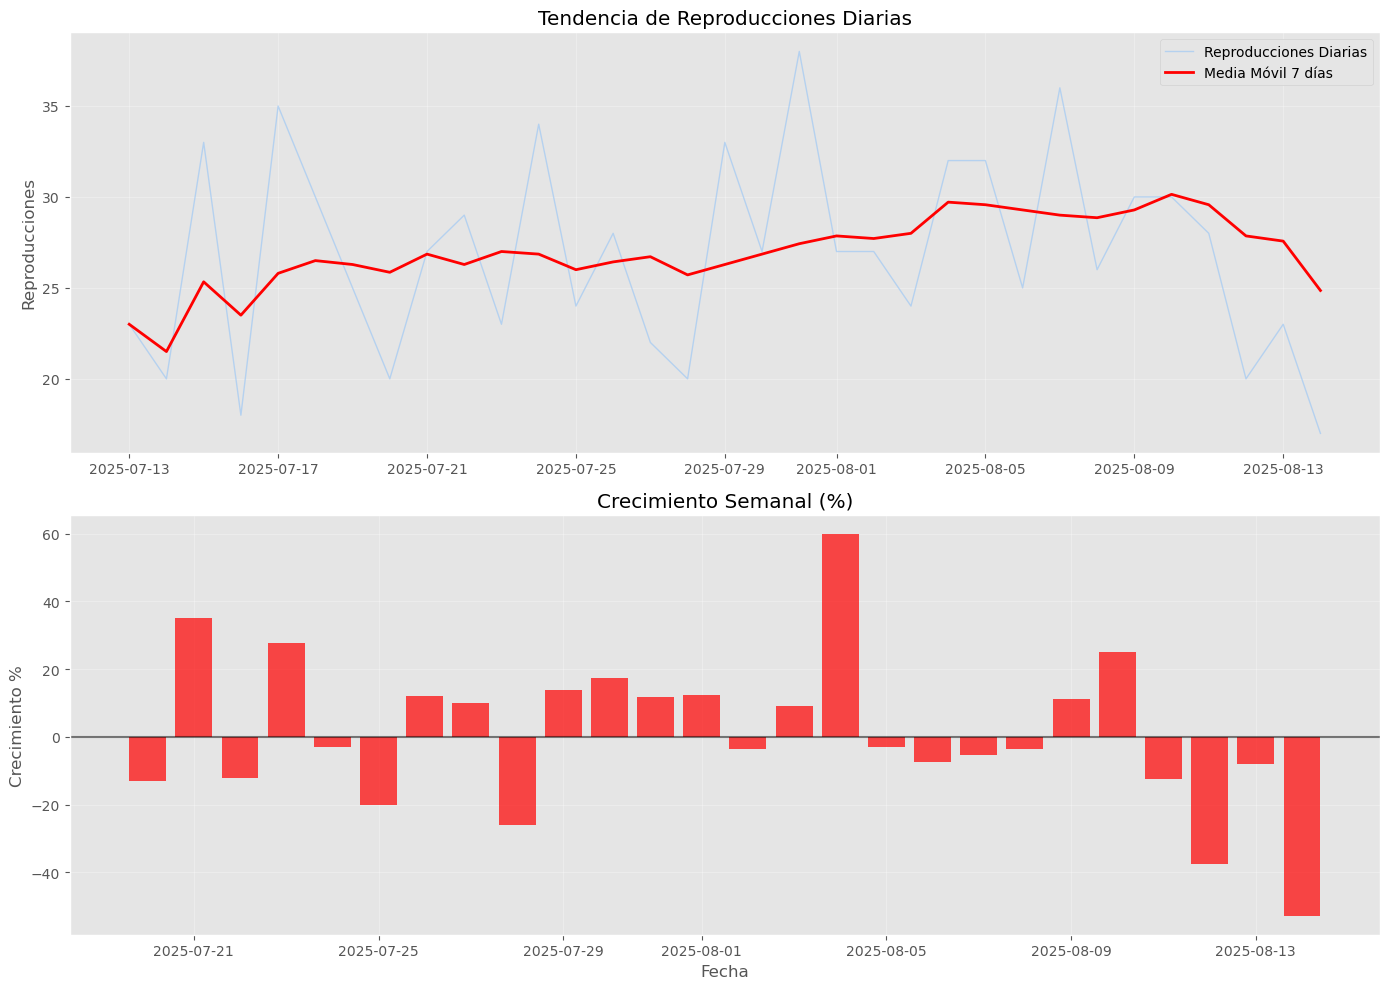

In [14]:
query_5 = """
WITH crecimiento_diario AS (
    SELECT 
        DATE_TRUNC('day', p.start_time) as fecha,
        COUNT(p.play_id) as reproducciones_dia,
        SUM(COUNT(p.play_id)) OVER (ORDER BY DATE_TRUNC('day', p.start_time)) as reproducciones_acumuladas,
        AVG(COUNT(p.play_id)) OVER (ORDER BY DATE_TRUNC('day', p.start_time) ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) as media_movil_7d,
        LAG(COUNT(p.play_id), 7) OVER (ORDER BY DATE_TRUNC('day', p.start_time)) as reproducciones_semana_anterior
    FROM plays p
    WHERE p.start_time >= CURRENT_DATE - INTERVAL '60 days'
    GROUP BY DATE_TRUNC('day', p.start_time)
)
SELECT 
    fecha,
    reproducciones_dia,
    reproducciones_acumuladas,
    media_movil_7d,
    reproducciones_semana_anterior,
    (reproducciones_dia::float / reproducciones_semana_anterior - 1) * 100 as crecimiento_semanal
FROM crecimiento_diario
ORDER BY fecha;
"""

df_crecimiento_diario = pd.read_sql(query_5, conn)
df_crecimiento_diario['fecha'] = pd.to_datetime(df_crecimiento_diario['fecha'])

# Gráfico de tendencia temporal
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Reproducciones diarias y media móvil
axes[0].plot(df_crecimiento_diario['fecha'], df_crecimiento_diario['reproducciones_dia'], 
            label='Reproducciones Diarias', alpha=0.7, linewidth=1)
axes[0].plot(df_crecimiento_diario['fecha'], df_crecimiento_diario['media_movil_7d'], 
            label='Media Móvil 7 días', linewidth=2, color='red')
axes[0].set_title('Tendencia de Reproducciones Diarias')
axes[0].set_ylabel('Reproducciones')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Crecimiento semanal
axes[1].bar(df_crecimiento_diario['fecha'], df_crecimiento_diario['crecimiento_semanal'], 
           alpha=0.7, color='green' if df_crecimiento_diario['crecimiento_semanal'].iloc[-1] > 0 else 'red')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].set_title('Crecimiento Semanal (%)')
axes[1].set_ylabel('Crecimiento %')
axes[1].set_xlabel('Fecha')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

El primer gráfico, que muestra las reproducciones diarias, revela una tendencia general al alza en la cantidad de reproducciones durante el periodo. Aunque hay fluctuaciones significativas, la línea de la media móvil de 7 días (la línea roja) muestra que, en promedio, las reproducciones fueron aumentando.
Las líneas en el primer gráfico indican una alta variabilidad en las reproducciones diarias. Esto sugiere que ciertos días de la semana o eventos específicos pueden influir en el número de reproducciones. Aparentemente, las reproducciones bajan los fines de semana (por ejemplo, alrededor del 20 de julio y el 10 de agosto) y aumentan a mitad de semana.
El segundo gráfico, que representa el crecimiento semanal en porcentaje, ofrece una visión más clara de la volatilidad:
Hay picos de crecimiento positivo notables, como a mediados de julio y principios de agosto (alrededor del 4 de agosto, con un crecimiento de casi el 60%).
También hay períodos de crecimiento negativo significativos, especialmente hacia finales de julio y mediados de agosto. La caída más notable ocurre en la última semana, con un decrecimiento de más del 50%.

#### Comportamiento de usuarios nuevos vs existentes

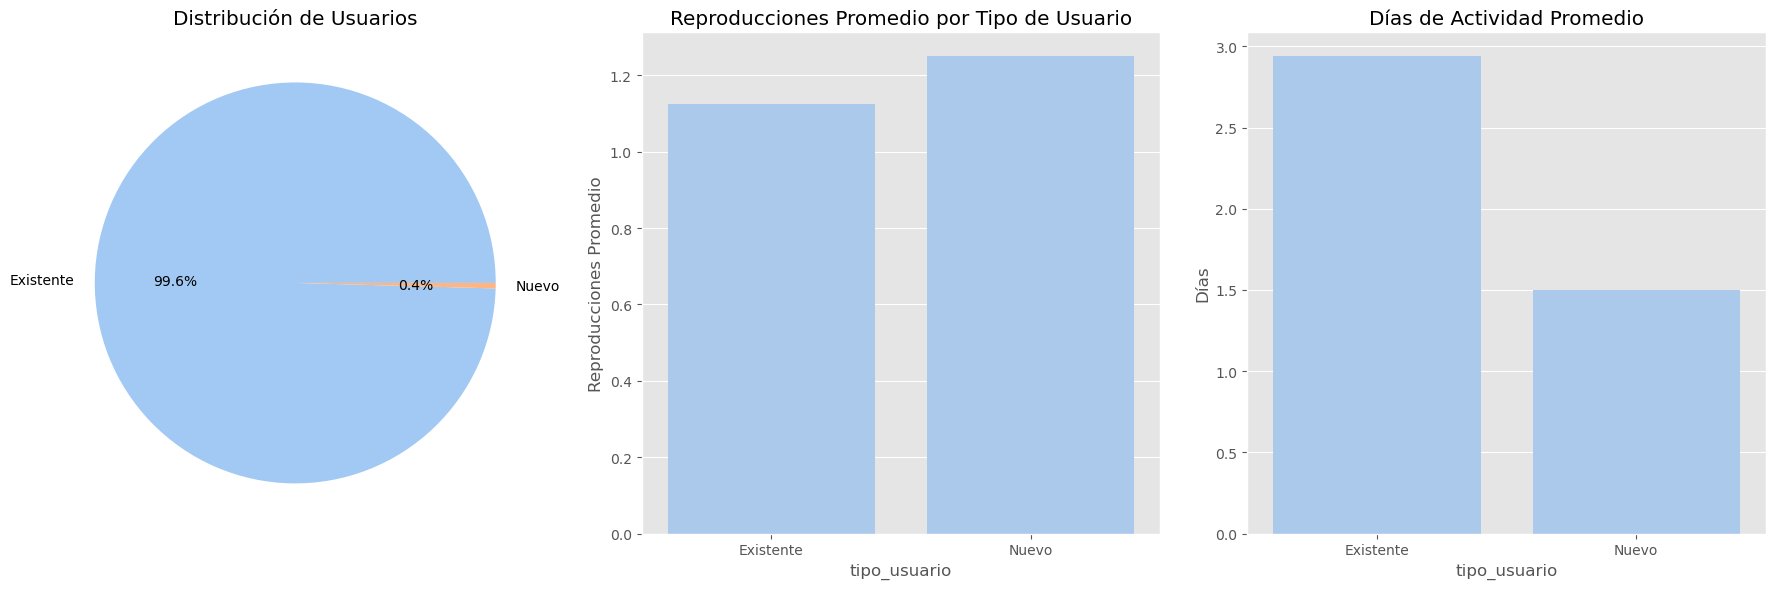

In [27]:
query_6 = """
WITH actividad_usuario AS (
    SELECT 
        u.user_id,
        u.registration_date,
        FIRST_VALUE(p.start_time) OVER (PARTITION BY u.user_id ORDER BY p.start_time) as primera_reproduccion,
        LAST_VALUE(p.start_time) OVER (PARTITION BY u.user_id ORDER BY p.start_time ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as ultima_reproduccion,
        COUNT(p.play_id) OVER (PARTITION BY u.user_id) as total_reproducciones
    FROM users u
    JOIN plays p ON u.user_id = p.user_id
    WHERE p.start_time >= CURRENT_DATE - INTERVAL '90 days'
),
usuario_stats AS (
    SELECT DISTINCT
        user_id,
        registration_date,
        primera_reproduccion,
        ultima_reproduccion,
        total_reproducciones,
        (ultima_reproduccion - primera_reproduccion) as periodo_actividad,
        CASE 
            WHEN registration_date >= CURRENT_DATE - INTERVAL '30 days' THEN 'Nuevo'
            ELSE 'Existente'
        END as tipo_usuario
    FROM actividad_usuario
)
SELECT 
    tipo_usuario,
    COUNT(user_id) as total_usuarios,
    AVG(total_reproducciones) as reproducciones_promedio,
    AVG(EXTRACT(EPOCH FROM periodo_actividad)/86400) as dias_actividad_promedio,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_reproducciones) as mediana_reproducciones
FROM usuario_stats
GROUP BY tipo_usuario;
"""

df_comportamiento_usuarios = pd.read_sql(query_6, conn)

# Gráfico comparativo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total usuarios
axes[0].pie(df_comportamiento_usuarios['total_usuarios'], 
           labels=df_comportamiento_usuarios['tipo_usuario'], 
           autopct='%1.1f%%')
axes[0].set_title('Distribución de Usuarios')

# Reproducciones promedio
sns.barplot(data=df_comportamiento_usuarios, x='tipo_usuario', y='reproducciones_promedio', ax=axes[1])
axes[1].set_title('Reproducciones Promedio por Tipo de Usuario')
axes[1].set_ylabel('Reproducciones Promedio')

# Días de actividad
sns.barplot(data=df_comportamiento_usuarios, x='tipo_usuario', y='dias_actividad_promedio', ax=axes[2])
axes[2].set_title('Días de Actividad Promedio')
axes[2].set_ylabel('Días')

plt.tight_layout()
plt.show()

la plataforma tiene una base de usuarios muy sólida y estable, con los usuarios existentes siendo la fuerza principal. Sin embargo, hay un desafío claro con los usuarios nuevos: aunque pueden ser inicialmente más activos por sesión (ligeramente), no se quedan. La baja tasa de retención de los nuevos usuarios (menos días de actividad) es un área clave para mejorar si la plataforma busca crecer. Se podría investigar por qué los nuevos usuarios no regresan para ver si el proceso de registro o las primeras impresiones se pueden optimizar.

#### Combinaciones de géneros por contenido

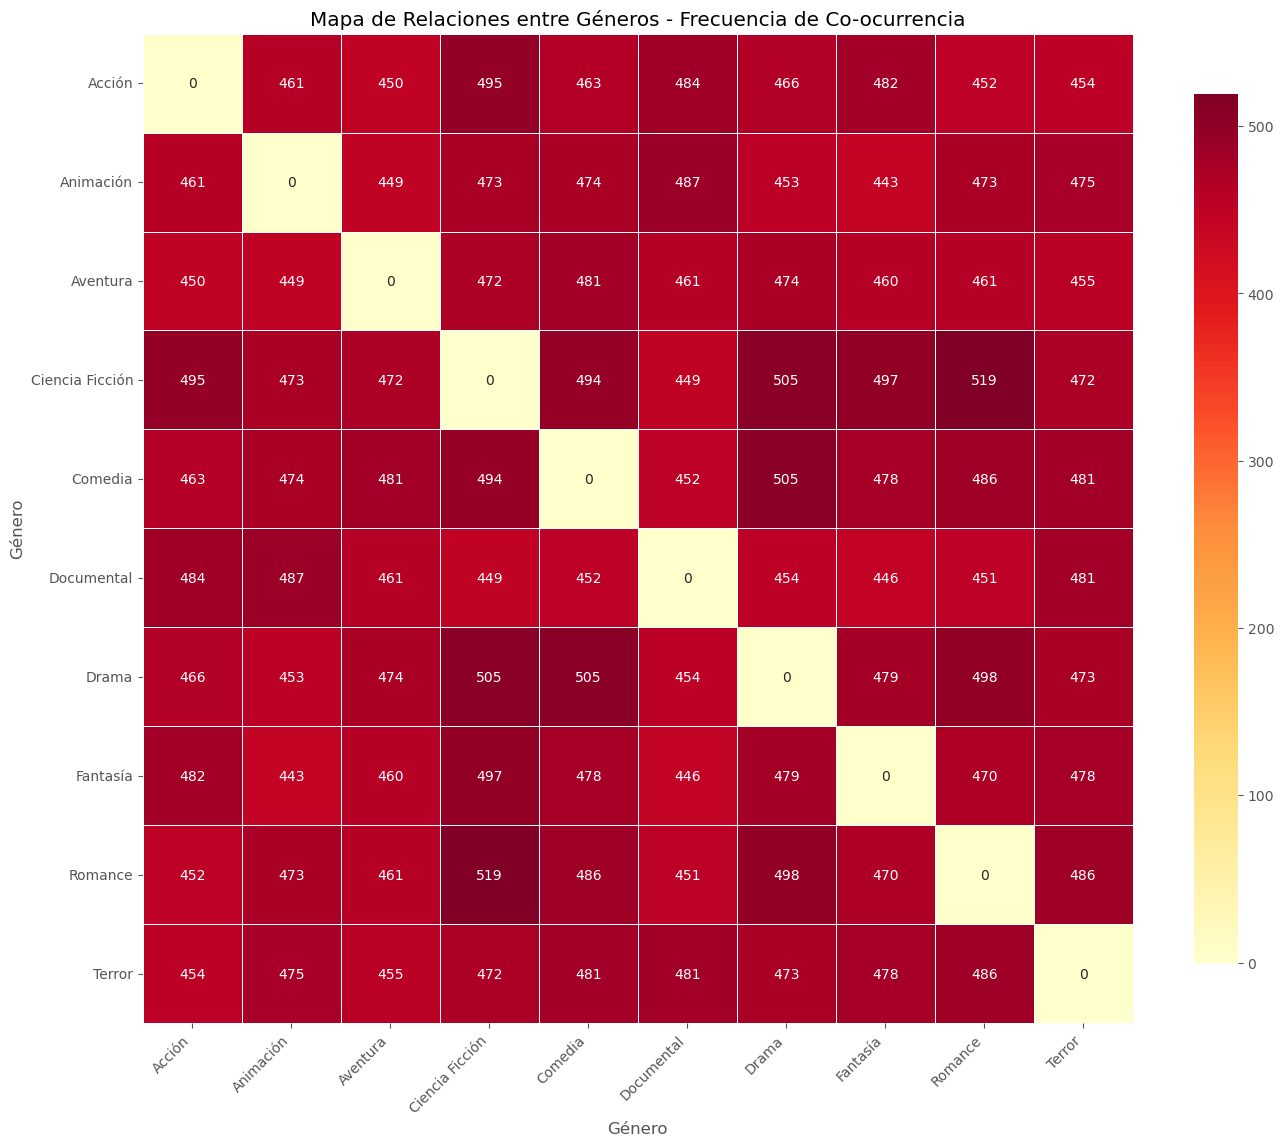

In [10]:
# Consulta para obtener las combinaciones de géneros por contenido
query_relaciones_generos = """
SELECT 
    cg1.genre_id as genre_id1, 
    g1.name as genre_name1,
    cg2.genre_id as genre_id2, 
    g2.name as genre_name2,
    COUNT(DISTINCT cg1.content_id) as frecuencia
FROM content_genres cg1
JOIN content_genres cg2 ON cg1.content_id = cg2.content_id AND cg1.genre_id < cg2.genre_id
JOIN genres g1 ON cg1.genre_id = g1.genre_id
JOIN genres g2 ON cg2.genre_id = g2.genre_id
GROUP BY cg1.genre_id, cg2.genre_id, g1.name, g2.name
ORDER BY frecuencia DESC;
"""

df_relaciones_generos = pd.read_sql(query_relaciones_generos, conn)

# Crear una matriz de relaciones entre géneros
generos_unicos = sorted(set(df_relaciones_generos['genre_name1'].unique()) | set(df_relaciones_generos['genre_name2'].unique()))
matriz_relaciones = pd.DataFrame(0, index=generos_unicos, columns=generos_unicos)

# Llenar la matriz con las frecuencias
for _, row in df_relaciones_generos.iterrows():
    genre1 = row['genre_name1']
    genre2 = row['genre_name2']
    frecuencia = row['frecuencia']
    matriz_relaciones.loc[genre1, genre2] = frecuencia
    matriz_relaciones.loc[genre2, genre1] = frecuencia

# Crear el mapa de calor
plt.figure(figsize=(14, 12))
sns.heatmap(matriz_relaciones, annot=True, fmt='d', cmap='YlOrRd', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Mapa de Relaciones entre Géneros - Frecuencia de Co-ocurrencia')
plt.xlabel('Género')
plt.ylabel('Género')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('imagen1.pdf') 
plt.show()


* Mayor co-ocurrencia entre Ciencia Ficción y Documental, y entre Comedia y Documental. El par de géneros con la mayor frecuencia de co-ocurrencia es Ciencia Ficción y Documental, seguido por Comedia y Documental, ambos con 505 co-ocurrencias.
* Alta co-ocurrencia en el género de Ciencia Ficción. Además de su relación con el Documental, Ciencia Ficción también tiene una alta co-ocurrencia con el género Terror, con 497, y con Animación, con 495.
* Baja co-ocurrencia en el género de Documental. Por otro lado, la co-ocurrencia más baja en la tabla se encuentra entre el género Documental y el género Acción, con 0 co-ocurrencias.

#### Análisis de cancelación de suscripciones y abandono del servicio

In [27]:
#  Análisis de patrones de cancelación de suscripciones
query_cancelaciones = """
SELECT 
    s.status,
    COUNT(*) AS total,
    AVG((s.end_date - s.start_date)) AS duracion_promedio_dias,
    s.payment_method,
    sp.name AS plan,
    sp.price_monthly
FROM subscriptions s
JOIN subscription_plans sp ON s.plan_id = sp.plan_id
GROUP BY s.status, s.payment_method, sp.name, sp.price_monthly
ORDER BY s.status, total DESC;
"""

df_cancelaciones = pd.read_sql(query_cancelaciones, conn)
df_cancelaciones

,status,total,duracion_promedio_dias,payment_method,plan,price_monthly
0,active,775,230 days 01:23:04.615385,credit_card,Premium,13.99
1,active,774,218 days 06:20:54.193548,gift_card,Estándar,10.99
2,active,765,218 days 21:02:27.945205,gift_card,Básico,7.99
3,active,758,238 days 10:21:22.191781,paypal,Premium,13.99
4,active,748,228 days 01:24:42.352941,paypal,Básico,7.99
5,active,744,222 days 12:59:00.983607,paypal,Estándar,10.99
6,active,729,224 days 07:42:32.727273,credit_card,Básico,7.99
7,active,719,237 days 11:50:08.219178,credit_card,Estándar,10.99
8,active,708,241 days 00:09:10.318471,gift_card,Premium,13.99
9,canceled,203,145 days 10:32:11.707317,paypal,Estándar,10.99


La tabla muestra que los usuarios que cancelaron el servicio tienen una duración de suscripción promedio más corta que los usuarios activos. Además, los usuarios cancelados se distribuyen entre los distintos planes (Premium, Estándar, y Básico) y métodos de pago (tarjeta de crédito, gift card, y paypal) de manera similar a los usuarios activos. Esto sugiere que ni el plan de suscripción ni el método de pago son factores determinantes en las cancelaciones.

#### Análisis de retención de usuarios

In [26]:
query_retention = """
WITH user_activity AS (
    SELECT 
        u.user_id,
        u.name,
        u.registration_date,
        u.last_login,
        s.status as subscription_status,
        s.end_date as subscription_end,
        COUNT(p.play_id) as total_plays,
        MAX(p.start_time) as last_play_date,
        -- Días desde la última actividad
        (CURRENT_DATE - u.last_login::date) as days_since_last_login,
        (CURRENT_DATE - GREATEST(
            COALESCE(MAX(p.start_time)::date, u.last_login::date)
        )) as days_since_last_activity,
        -- Estado de la suscripción
        CASE 
            WHEN s.status = 'active' AND s.end_date > CURRENT_DATE THEN 'active'
            WHEN s.status = 'cancelled' OR s.end_date <= CURRENT_DATE THEN 'cancelled'
            ELSE 'unknown'
        END as current_subscription_status
    FROM users u
    LEFT JOIN subscriptions s ON u.user_id = s.user_id
    LEFT JOIN plays p ON u.user_id = p.user_id
    GROUP BY u.user_id, u.name, u.registration_date, u.last_login, s.status, s.end_date
),
inactive_users AS (
    SELECT 
        user_id,
        name,
        registration_date,
        last_login,
        subscription_status,
        subscription_end,
        total_plays,
        last_play_date,
        days_since_last_login,
        days_since_last_activity,
        current_subscription_status,
        -- Categorizar razón de inactividad
        CASE 
            WHEN days_since_last_activity > 90 AND current_subscription_status = 'cancelled' THEN 'Inactivo y suscripción cancelada'
            WHEN days_since_last_activity > 90 THEN 'Inactivo prolongado'
            WHEN current_subscription_status = 'cancelled' AND days_since_last_activity <= 90 THEN 'Suscripción cancelada recientemente'
            WHEN total_plays = 0 THEN 'Nunca usó el servicio'
            ELSE 'Activo'
        END as churn_reason
    FROM user_activity
)
SELECT 
    churn_reason,
    COUNT(*) as user_count,
    AVG(days_since_last_activity) as avg_days_inactive,
    AVG(total_plays) as avg_plays,
    MIN(last_login) as earliest_last_login,
    MAX(last_login) as latest_last_login
FROM inactive_users
GROUP BY churn_reason
ORDER BY user_count DESC;
"""

df_retention = pd.read_sql(query_retention, conn)
df_retention


,churn_reason,user_count,avg_days_inactive,avg_plays,earliest_last_login,latest_last_login
0,Inactivo prolongado,5055,225.290603,1.085856,2024-08-13,2025-08-13
1,Inactivo y suscripción cancelada,1311,228.743707,1.117468,2024-08-13,2025-08-13
2,Activo,1291,58.718823,2.103021,2024-08-14,2025-08-13
3,Suscripción cancelada recientemente,397,57.564232,1.690176,2024-08-13,2025-08-13
4,Nunca usó el servicio,286,61.041958,0.000000,2025-06-13,2025-08-13


La tabla indica que la mayoría de los usuarios que han cancelado o que ya no usan el servicio se clasifican como inactivos prolongados (5055 usuarios) o inactivos y con suscripción cancelada (1311 usuarios). Esto resalta que la inactividad del usuario es un factor clave en la pérdida de clientes. Aunque la cantidad de usuarios con una suscripción cancelada recientemente es menor (397), su promedio de días inactivos es mucho más bajo (57.56 días) que los grupos inactivos prolongados (225.29 días) y los usuarios con suscripción cancelada (228.74 días), lo que sugiere que algunos usuarios cancelan poco después de dejar de usar el servicio.

#### Análisis temporal de cuándo ocurren las cancelaciones

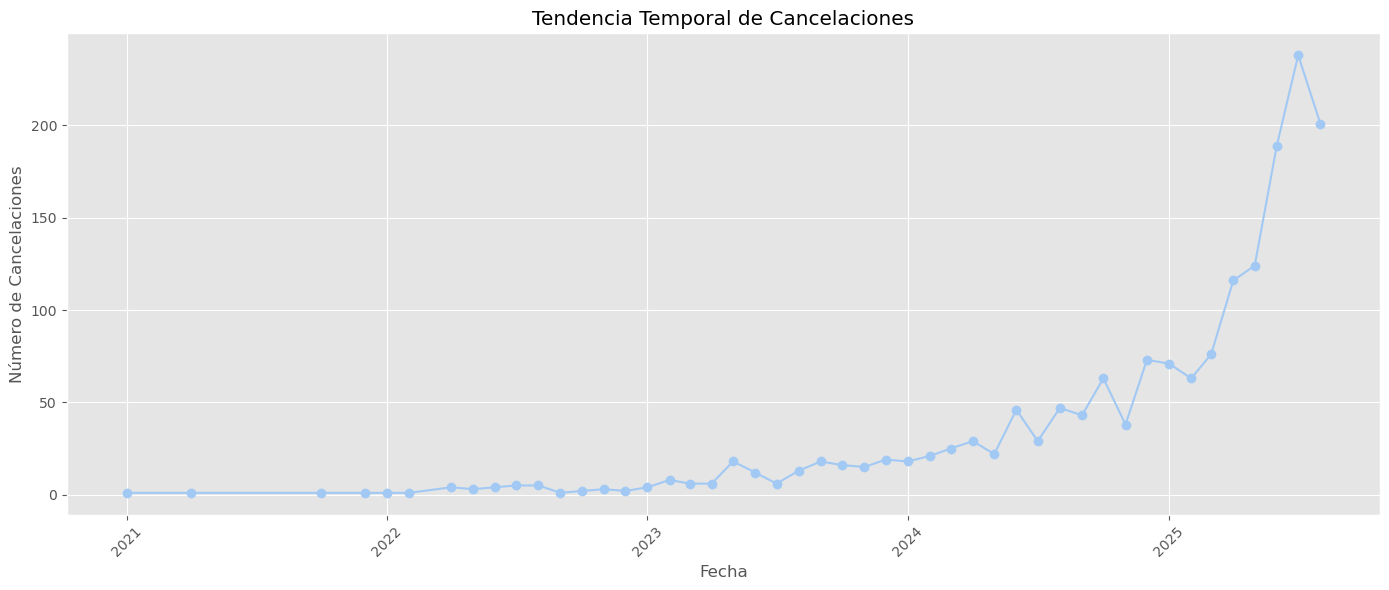

In [28]:
query_temporal_analysis = """
SELECT 
    EXTRACT(MONTH FROM s.end_date) as cancellation_month,
    EXTRACT(YEAR FROM s.end_date) as cancellation_year,
    COUNT(*) as cancellation_count,
    AVG((s.end_date - u.registration_date)) as avg_days_until_cancellation
FROM subscriptions s
JOIN users u ON s.user_id = u.user_id
WHERE s.status = 'cancelled' OR s.end_date <= CURRENT_DATE
GROUP BY EXTRACT(YEAR FROM s.end_date), EXTRACT(MONTH FROM s.end_date)
ORDER BY cancellation_year, cancellation_month;
"""

df_temporal = pd.read_sql(query_temporal_analysis, conn)
df_temporal["cancellation_date"] = pd.to_datetime(
    df_temporal[["cancellation_year", "cancellation_month"]]
    .assign(day=1)
    .rename(columns={"cancellation_year": "year", "cancellation_month": "month"})
)
plt.figure(figsize=(14, 6))
plt.plot(df_temporal['cancellation_date'], df_temporal['cancellation_count'], marker='o')
plt.title('Tendencia Temporal de Cancelaciones')
plt.xlabel('Fecha')
plt.ylabel('Número de Cancelaciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El gráfico muestra un aumento exponencial en el número de cancelaciones a partir de mediados de 2024. Este incremento se acentúa significativamente a finales de 2024 y principios de 2025, alcanzando su punto más alto en 2025. Este patrón sugiere un problema reciente y grave con la retención de clientes.

#### Correlación entre variables de uso

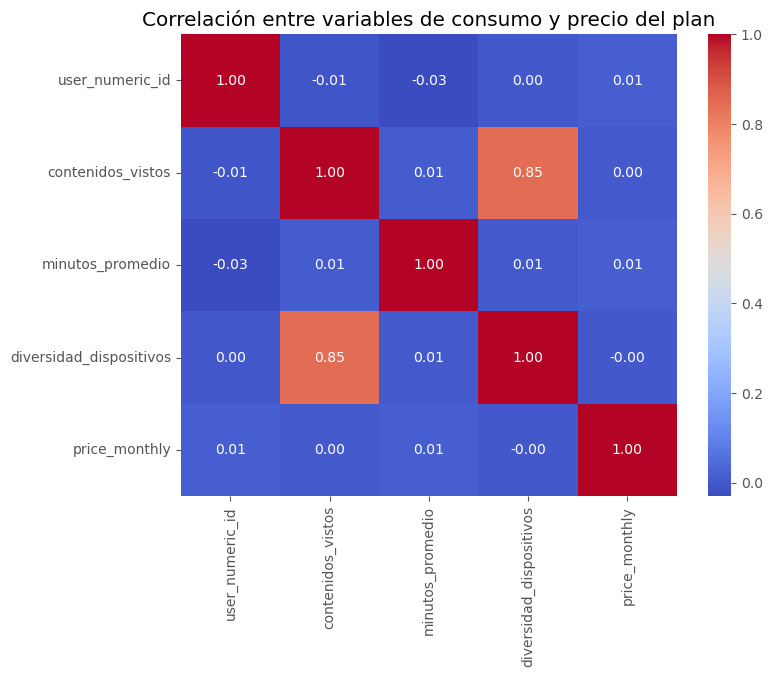

In [8]:
query_corr = """
WITH usuarios AS (
    SELECT 
        u.user_id,
        ROW_NUMBER() OVER (ORDER BY u.user_id) AS user_numeric_id
    FROM users u
)
SELECT 
    usr.user_numeric_id,
    COUNT(DISTINCT p.content_id) AS contenidos_vistos,
    AVG(EXTRACT(EPOCH FROM (p.end_time - p.start_time))/60) AS minutos_promedio,
    COUNT(DISTINCT p.device_type) AS diversidad_dispositivos,
    sp.price_monthly
FROM usuarios usr
JOIN plays p ON usr.user_id = p.user_id
JOIN subscriptions s ON usr.user_id = s.user_id
JOIN subscription_plans sp ON s.plan_id = sp.plan_id
WHERE p.end_time IS NOT NULL
GROUP BY usr.user_numeric_id, sp.price_monthly;
"""

df_corr = pd.read_sql(query_corr, conn)

# Seleccionar solo columnas numéricas
df_corr_num = df_corr.select_dtypes(include=[np.number])

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr_num.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables de consumo y precio del plan")
plt.show()

* Correlación fuerte: la variable contenidos_vistos y diversidad_dispositivos tienen una correlación muy alta (0.85). Esto indica que los usuarios que ven más contenidos tienden también a usar más tipos de dispositivos.
* Correlación baja con el precio: la variable price_monthly no tiene correlación significativa con las demás variables. Esto sugiere que el precio del plan no está influyendo directamente en el comportamiento de consumo de contenidos ni en la diversidad de dispositivos.
* Otras variables (minutos_promedio) muestran prácticamente independencia respecto a las demás, lo cual indica que el tiempo promedio no está fuertemente relacionado con cantidad de contenidos ni con diversidad de dispositivos.

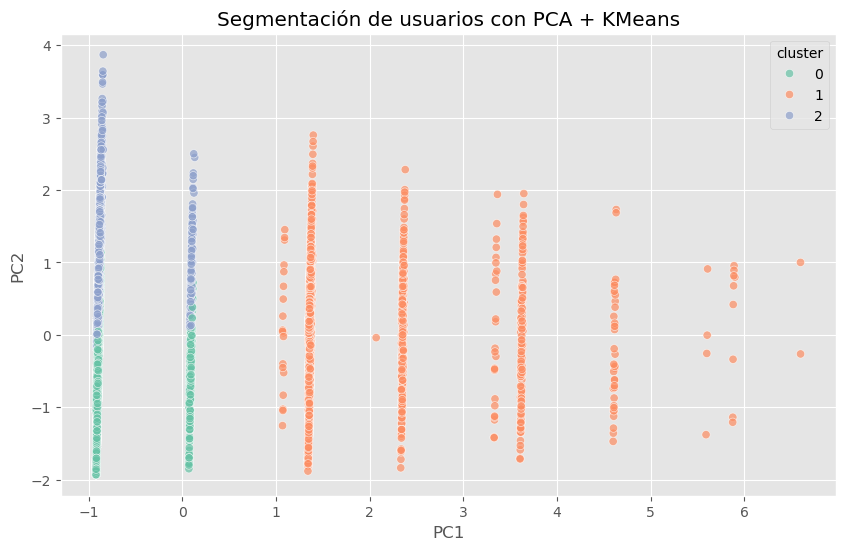

In [19]:
#Se usa el dataset de correlación como base
#Se elimina la columna de ID porque no aporta a la segmentación.
X = df_corr.drop(columns=["user_numeric_id"])
scaler = StandardScaler()
#Se normaliza todas las variables (media = 0, desviación estándar = 1).
X_scaled = scaler.fit_transform(X)

# PCA para reducción a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["user_id"] = df_corr["user_numeric_id"]

# Clustering con KMeans
# Se elige aleatoriamente k centroides
# Asigna cada usuario al centroide más cercano
kmeans = KMeans(n_clusters=3, random_state=42)

df_pca["cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="cluster",
    data=df_pca,
    palette="Set2",
    alpha=0.7
)
plt.title("Segmentación de usuarios con PCA + KMeans")
plt.show()

* El PCA reduce las dimensiones y permite visualizar la variabilidad.
* El gráfico muestra que la mayoría de los usuarios están concentrados en un mismo cluster (color naranja, cluster 1).
* Los clusters 0 y 2 aparecen mucho más pequeños y cercanos al eje de PC1, lo que indica que representan minorías dentro de la base de usuarios.
* La separación no es muy clara con PCA.

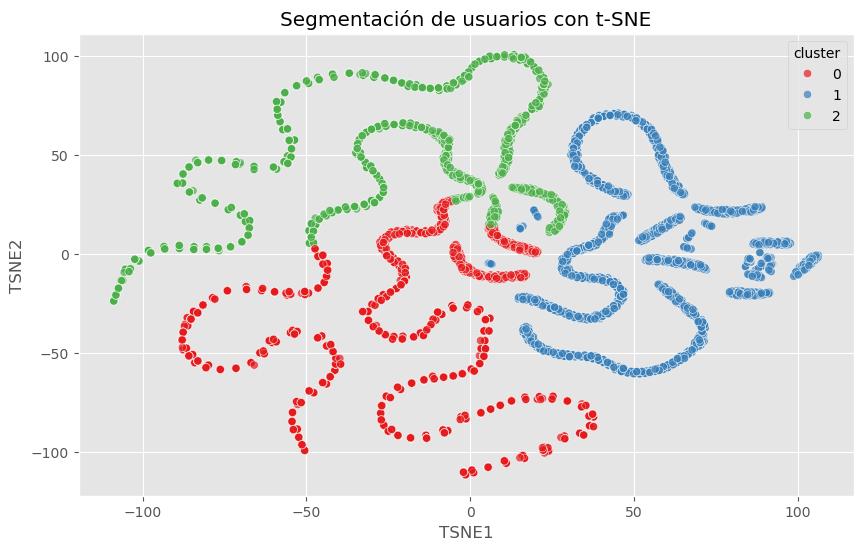

In [14]:
#t-SNE es una técnica de reducción de dimensionalidad no lineal.
#perplexity=30: define una especie de "vecindad efectiva"
#random_state=42: asegura reproducibilidad.
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["cluster"] = df_pca["cluster"]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="cluster",
    data=df_tsne,
    palette="Set1",
    alpha=0.7
)
plt.title("Segmentación de usuarios con t-SNE")
plt.show()

El t-SNE muestra una separación mucho más clara entre los clusters.
Aquí se ven tres grupos definidos:
* Cluster rojo: usuarios con un patrón de consumo diferente (alta diversidad o mayor engagement).
* Cluster verde: un grupo intermedio.
* Cluster azul: otro grupo bien diferenciado.\
A diferencia del PCA, el t-SNE refleja no linealidades, por eso la segmentación es más intuitiva.\
Estos clusters podrían usarse para personalizar estrategias:
* Cluster 1 (masivo): usuarios con consumo medio, quizás mantenerlos fidelizados.
* Cluster 0: usuarios menos activos, podrían necesitar incentivos para aumentar su consumo.
* Cluster 2: clave para retención y venta de upgrades.

## Conclusión

La empresa enfrenta un problema de retención de clientes que se ha vuelto crítico recientemente. El principal impulsor de las cancelaciones parece ser la inactividad prolongada de los usuarios, lo cual sugiere que el servicio no está siendo lo suficientemente atractivo o valioso para mantener a los clientes comprometidos a largo plazo.
Aunque la mayoría de los usuarios con inactividad prolongada ya han cancelado su suscripción, también hay un número considerable de usuarios "Inactivos prolongados" que aún no han cancelado, pero podrían hacerlo en el futuro. Es importante prestarles atención para prevenir futuras cancelaciones.
En resumen, la clave para reducir la tasa de cancelación y revertir la tendencia creciente de cancelaciones está en idear estrategias para aumentar la participación de los usuarios y reactivar a aquellos que se han vuelto inactivos.